# <h1 style="text-align: center; font-size: 36px; color: #3498db; font-weight: bold;">Prosody </h1>
## <h2 style="text-align: center; font-size: 28px; color: #2ecc71; font-weight: bold;">Prosody Active Emotion</h2>


In [41]:
##############
# Library
##############

import tkinter as tk
from tkinter import ttk
import pyaudio
import wave
import tensorflow as tf 
import os 
import pickle
import numpy as np
import librosa
import pandas as pd
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import librosa.effects
from joblib import Parallel, delayed
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from playsound import playsound
from datetime import datetime, timezone
from tkinter import messagebox, Checkbutton, Radiobutton
import re
import shutil

In [42]:
#########################################################################################################
# Cloud Folder
import os 
if not os.path.exists("Models"):
    import gdown
    folder_url =r"https://drive.google.com/drive/folders/1EZL6Ejoa5GH8DzoZcjvRAonlgWznEh14?usp=drive_link" 
    gdown.download_folder(folder_url)
##########################################################################################################


In [43]:
import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.12.0
Keras version: 2.12.0


In [44]:
###############################################
# loding the model, weights, scaler and encoder
###############################################

#prosody_model = tf.keras.models.load_model(r'./Models/Prosody_Active_Model_0.keras')
prosody_model = tf.keras.models.load_model(r'./Models/Prosody_Model.keras')

print ("Prosody Model has been loaded")

# loding the Scaler
with open(r"./Models/Prosody_Scaler.pickle", 'rb') as f:
    prosody_scaler = pickle.load(f)

# loding the Encoder    
with open(r"./Models/Prosody_Encoder.pickle", 'rb') as f:
    prosody_encoder = pickle.load(f)

global PREDICTED_CLASS     
OUTPUT_FILE=r"./Output/input_voice.wav"
Output_folder= r"./Output"
if not os.path.exists(Output_folder):    
    os.makedirs(Output_folder)

Prosody Model has been loaded


c:\Users\Alkostan-GIGA\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Alkostan-GIGA\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.4.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [45]:
#####################
# Functions section #
#####################################
# geting the features from the voice
#####################################

## ZCR: Zero Crossing Rate: The rate of sign changes of the signal during the duration of a particular frame
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

## RMS: root mean square value
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

## MFCC: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

## Extraxing the features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

###############################
# features extraxtion function
###############################
def get_features(path):
    
    data, sr= librosa.load(path, duration=2.5, offset=0) # Extract for 2.5 seconds
    
    result=extract_features(data)
    result=np.array(result)
    result = np.reshape(result, (1, -1))
    result = prosody_scaler.transform(result)  # Scaler
    
    return result

######################
# Prediction function
######################
def prediction(path):
    result = get_features(path)
    prediction = prosody_model.predict(result)
    y_prediction = prosody_encoder.inverse_transform(prediction.reshape(1, -1))
    predicted_class = y_prediction[0][0]
    # class probabilities
    predicted_probs = prediction[0]
    # class names from encoder
    class_names = prosody_encoder.categories_[0]
    ''''
    # Print predicted class and probabilities for all classes
    print("Predictions for all classes:")
    for label, prob in zip(class_names, predicted_probs):
        print(f"{label}: {prob*100:.2f}%")
    '''
    return predicted_class, predicted_probs


###################
# Database Function
###################
def df_database_function(database_folder):
    
    datagrams = []
    for filename in os.listdir(database_folder):
        if filename.endswith('.wav'):
            emotion = filename.split('_')[0]
            file_path = os.path.join(database_folder, filename)
            datagram = {'path': file_path, 'Emotions': emotion}
            datagrams.append(datagram)
            
    df0 = pd.DataFrame(datagrams)

    ##########################
    # Extraction process
    ###########################
    def extraction_process(path, emotion):
        features = get_features(path)
        X = []
        Y = []
        for ele in features:
            X.append(ele)
            Y.append(emotion)
        return X, Y
    
    paths = df0.path
    emotions = df0.Emotions
    ##########################%%%%%% this parallel loop is chaotic in a sensse that things no longer remian in a particular order as in the df0!################################
    # parallel loop 
    results = Parallel(n_jobs=-1)(delayed(extraction_process)(path, emotion) for (path, emotion) in zip(paths, emotions))
    X = []
    Y = []
    for result in results:
        x, y = result
        X.extend(x)
        Y.extend(y)
    df = pd.DataFrame(X)
    df['Emotions'] = Y
    
    return df

############################
# Model Fine-Tune 
############################

def get_date_string():
    current_datetime = datetime.now(timezone.utc)

    # Format the datetime as desired
    formatted_datetime = current_datetime.strftime('%Y_%m_%d_%H-%M')
    return formatted_datetime

def get_latest_experiment(experiments_dir = r"tmp"):

    # List all folders in the experiments directory
    experiment_folders = [folder for folder in os.listdir(experiments_dir)]
    if not experiment_folders: #check if empty
        return "exp_" + get_date_string()
    
    # Parse folder names and extract datetime information
    parsed_folders = []
    for folder_name in experiment_folders:
        try:
            folder_datetime = datetime.strptime(folder_name, 'exp_%Y_%m_%d_%H-%M')
            parsed_folders.append((folder_datetime, folder_name))
        except ValueError:
            print(ValueError)
            # Skip folders with names not matching the expected format
            pass

    # Sort the parsed folders based on datetime
    sorted_folders = sorted(parsed_folders, key=lambda x: x[0], reverse=True)

    # Retrieve the latest folder name
    latest_folder = sorted_folders[0][1] if sorted_folders else None

    print("Latest experiment folder:", latest_folder)

    return latest_folder

new_experiment = True

def model_finetune(df):
    X= df.iloc[: ,:-1]
    y = df['Emotions']
    X = prosody_scaler.transform(X)
    y = prosody_encoder.transform(y.to_numpy().reshape(-1, 1)).toarray()  # no fit_transform as it will remove the previous state and will only have as many classes as in the current dataset
    X_cnn = np.expand_dims(X, axis=2)
    
    if new_experiment: 
        exp_dir = f"tmp/exp_{get_date_string()}"
    else: 
        exp_dir = get_latest_experiment(experiments_dir=r"tmp")
        
    # checkpoint_path = os.path.join(exp_dir, r"ckpts/Model_{epoch:02d}-{accuracy:.2f}-{loss:.4f}.keras")
    checkpoint_path = exp_dir + r"/ckpts/Model_{epoch:02d}-{accuracy:.2f}-{loss:.4f}.keras"
    
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, save_weights_only=False)

    early_stop = EarlyStopping(monitor='loss', mode='auto', patience=5, restore_best_weights=True)

    lr_reduction = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
    optimiser = Adam(learning_rate= 1e-3)
    prosody_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])

    history = prosody_model.fit(X_cnn, y, epochs=50, batch_size=64, callbacks=[early_stop, lr_reduction, model_checkpoint])
    history_path = exp_dir + '/history.pkl'
    ###save the history
    with open(history_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
        
    ########################
    # Save fine-tuned model
    ########################
    prosody_model.save(r'./Models/Prosody_Active_Model.keras')
    print('prosody active model saved')
    

# database_folder = r"./new_recordings"
# df_new = df_database_function(database_folder)


## <h2 style="text-align: left; font-size: 28px; color: #2ecc71; font-weight: bold;">Prosody Real-time & Prosody Active</h2>

In [46]:
####################################
# Prosody Real-Time & Prosody Active
####################################
# Ubdate prosody active Model
###############################
if os.path.exists(r'./Models/Prosody_Active_Model.keras'):
    prosody_model = tf.keras.models.load_model(r'./Models/Prosody_Active_Model.keras')
    print ("Prosody active model has been loaded")
######################################################################################    

class EmotionPlotter:
    def __init__(self, root, update_callback):
        self.root = root
        self.root.lift()
        self.root.title("Emotion Prediction")
        
        frame_color= '#F5F5F5'
        #self.root.configure(bg='#2c3e50')
        self.root.configure(bg=frame_color)
        self.update_callback = update_callback
        self.class_names = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.fig, self.ax = plt.subplots(figsize=(10, 4.5))  # Set the facecolor to dark mode
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=0)
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.root)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
        #########################
        # Recording configuration
        #########################
        self.RECORD_SECONDS = 2.5  # recording duration
        self.FORMAT = pyaudio.paInt16
        self.CHANNELS = 1
        self.RATE = 44100
        self.CHUNK = 1024
        self.CHUNK_SIZE = 1024
        self.OUTPUT_FILE = OUTPUT_FILE
        #######################################################################
        #########################
        # buttons configuration
        ##########################
        # Button styles
        button_font = ('Helvetica', 14, 'bold')
        button_style = {
            'font': button_font,
            'bg': '#2c3e60',  # Green background
            'fg': 'white',    # White text
            'activebackground': '#2c3e55',  # Darker green when pressed
            'activeforeground': 'white',    # White text when pressed
            'borderwidth': 0,
            'padx': 10,
            'pady': 5
        }

        # Create a frame for the buttons
        button_frame = tk.Frame(self.root, bg=frame_color)
        button_frame.pack(side=tk.TOP, pady=(10, 10))

        # Start button
        self.start_button = tk.Button(
            button_frame, text="Start Recording",
            command=self.start_visualization,
            **button_style
        )
        self.start_button.pack(side=tk.LEFT, padx=10, pady=5)

        # Continue button
        self.continue_button = tk.Button(
            button_frame, text="Active Mode",
            command=self.active_mode,
            **button_style
        )
        self.continue_button.pack(side=tk.LEFT, padx=10, pady=5)
        self.continue_button['state'] = tk.DISABLED

        # Exit button
        self.exit_button = tk.Button(
            button_frame, text="Exit",
            command=self.root.destroy,
            **button_style
        )
        self.exit_button.pack(side=tk.RIGHT, padx=10, pady=5)
        self.exit_button['state'] = tk.NORMAL

        # Listen button
        self.listen_button = tk.Button(
            button_frame, text="Play the Voice",
            command=self.play_voice,
            **button_style
        )
        self.listen_button.pack(side=tk.RIGHT, padx=10, pady=5)
        self.listen_button['state'] = tk.DISABLED
        self.visualizing = False                 # track of visualization state
        self.root.after(0, self.center_window)  
        
    def center_window(self):
        self.root.update_idletasks()  
        width = self.root.winfo_width()
        height = self.root.winfo_height()
        x = (self.root.winfo_screenwidth() // 2) - (width // 2)
        y = (self.root.winfo_screenheight() // 2) - (height // 2)
        self.root.geometry(f'{width}x{height}+{x}+{y}')

    ############################################################
    ############################        
    # buttons update
    ##########################
    def start_visualization(self):
        if not self.visualizing:
            self.visualizing = True
            self.start_button['state'] = tk.DISABLED
            self.continue_button['state'] = tk.DISABLED
            self.listen_button['state'] = tk.DISABLED
            self.update_start_loop()
    
    def active_mode(self):
        if not self.visualizing:
            self.visualizing = True
            self.start_button['state'] = tk.DISABLED
            self.continue_button['state'] = tk.DISABLED
            self.listen_button['state'] = tk.DISABLED
            self.exit_button['state'] = tk.DISABLED
            self.visualizing = False       
        #OUTPUT_FILE=r"./Output/input_voice.wav"
        database_folder= r'./Database'
        self.Prosody_active(self.OUTPUT_FILE, database_folder, self.start_button, self.continue_button, self.listen_button, self.exit_button).active_GUI()
          
    def play_voice(self):
        playsound(OUTPUT_FILE)
        
    def update_start_text(self, text):
        self.start_button.config(text=text)
        self.root.update()
        
    def update_continue_text(self, text):
        self.continue_button.config(text=text)
        self.root.update()   
             
    def update_start_loop(self):
        ########################
        # Start recording audio
        ########################
        self.update_start_text("Recording in Progress...")
        print("Listening...")
        audio = pyaudio.PyAudio()
        stream = audio.open(format=self.FORMAT, channels=self.CHANNELS, rate=self.RATE, input=True, frames_per_buffer=self.CHUNK)
        frames = []
        # Recording 
        for i in range(0, int(self.RATE / self.CHUNK_SIZE * self.RECORD_SECONDS)):
            data = stream.read(self.CHUNK_SIZE)
            frames.append(data)
        # Stop recording
        stream.stop_stream()
        stream.close()
        audio.terminate()
        # Saving audio
        with wave.open(self.OUTPUT_FILE, 'wb') as wf:
            wf.setnchannels(self.CHANNELS)
            wf.setsampwidth(audio.get_sample_size(self.FORMAT))
            wf.setframerate(self.RATE)
            wf.writeframes(b''.join(frames))
             
        ######################
        # Perform prediction
        ######################
        self.update_start_text("Restart Recording")
        #self.update_continue("active Model")
        self.start_button['state'] = tk.NORMAL
        self.continue_button['state'] = tk.NORMAL
        self.listen_button['state'] = tk.NORMAL
        #######################
        global PREDICTED_CLASS
        #######################
        PREDICTED_CLASS, predicted_probs = prediction(self.OUTPUT_FILE)
        # callback
        self.update_callback(self, PREDICTED_CLASS, predicted_probs)
        # Reset visualization
        self.visualizing = False
        self.root.update() 
    ##################################################################
    ########################
    # Update Plot
    ########################
    def update_plot(self, predicted_probs):
        self.ax.clear()
        bars = self.ax.bar(self.class_names, predicted_probs * 100, color='blue')
        self.ax.set_title('Emotion Prediction')
        self.ax.set_xlabel('Emotion')
        self.ax.set_ylabel('Probability (%)')
        self.ax.set_ylim(0, 100)
        self.ax.set_xticks(np.arange(len(self.class_names)))
        self.ax.set_xticklabels(self.class_names, rotation=0)
        for i, bar in enumerate(bars):
            self.ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f'{predicted_probs[i]*100:.2f}%', ha='center', va='bottom')
        self.canvas.draw()
   
   
    #######################################################################################
    #######################################################################################
    # active-learning      
    #######################################################################################
    #######################################################################################
    class Prosody_active:
        def __init__ (self, output_file, output_folder, start_button, continue_button, listen_button,exit_button):
            self.start_button = start_button
            self.continue_button = continue_button
            self.listen_button = listen_button
            self.exit_button = exit_button
            
            self.OUTPUT_FILE = output_file
            self.database_folder = output_folder
            self.predicted_class = PREDICTED_CLASS
            self.classes = ['Noise', 'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
            self.selected_label = tk.StringVar()
            self.root = tk.Toplevel()               # giving active Gui Root other level as main Gui Root
            self.root.title("Prosody Active-Learning")
            self.root.geometry("700x200")
            self.selected_label.set(None)
            self.root.protocol("WM_DELETE_WINDOW", self.on_window_close)
            self.root.after(0, self.center_window)
            
        def center_window(self):
            self.root.update_idletasks()  
            width = self.root.winfo_width()
            height = self.root.winfo_height()
            x = (self.root.winfo_screenwidth() // 2) - (width // 2)
            y = (self.root.winfo_screenheight() // 2) - (height // 2)
            self.root.geometry(f'{width}x{height}+{x}+{y}')

        def on_window_close(self):
                # Reset button states when window is closed
                self.start_button['state'] = tk.NORMAL
                self.continue_button['state'] = tk.NORMAL
                self.listen_button['state'] = tk.NORMAL
                self.exit_button['state'] = tk.NORMAL
                # Destroy the window
                self.root.destroy()
        #######################
        # Data Folder structure
        #######################       
        def save_data(self, selected_value):    
            if not os.path.exists(self.database_folder):
                os.makedirs(self.database_folder)
                
            existing_files = [f for f in os.listdir(self.database_folder) if f.endswith('.wav')]
            ##########################
            # Find the max file value
            ##########################
            max_number = 0
            for file_name in existing_files:
                match = re.match(rf"{selected_value}_(\d+)\.wav", file_name)
                if match:
                    number = int(match.group(1))
                    max_number = max(max_number, number)
            ###########################   
            # save the file
            ###############
            new_file_name = f"{selected_value}_{max_number + 1}.wav"
            output_file_path = os.path.join(self.database_folder, new_file_name)
            shutil.copyfile(self.OUTPUT_FILE, output_file_path)
            print('saved to Database')
            ############################
            messagebox.showinfo("Success", "Information saved to Prosody Database.")
        #####################################################################################
        ############################
        # Fine Tune
        #############################
        def fine_tune(self, correct_label):
        
            print ('correct_label: ', correct_label)
            
            df_database = pd.DataFrame()
            df_database = df_database_function(self.database_folder)
            df_database.to_csv(r'./Models/df_Database.csv', index = False)
            model_finetune(df_database)

            messagebox.showinfo("Success", "Model retrained with the new information.")
            self.root.destroy()
        #################################################################################            
        ###########################
        # Save without training
        ###########################
        def B_save_data(self):
            selected_value = self.selected_label.get()
            if selected_value in self.classes:
                self.save_data(selected_value)
                print('Data saved without training. Selected label: ', selected_value)

                self.start_button['state'] = tk.NORMAL
                self.continue_button['state'] = tk.NORMAL
                self.listen_button['state'] = tk.NORMAL
                self.exit_button['state'] = tk.NORMAL
                self.visualizing = False
                self.root.update()
                
                if tk._default_root is not None:  # check root window exists
                    self.root.destroy()
        #########################################################################            
        ############################# 
        # Save and Retrain the model
        #############################
        def B_save_retrain(self):
            self.start_button.config(text='Retraining')
            self.continue_button.config(text='in')
            self.listen_button.config(text='progress')
            self.exit_button.config(text='...')
            
            selected_value = self.selected_label.get()
            if selected_value in self.classes:
                self.save_data(selected_value)
                self.fine_tune(selected_value)
                print('Selected label: ', selected_value)
                
                self.start_button['state'] = tk.NORMAL
                self.continue_button['state'] = tk.NORMAL
                self.listen_button['state'] = tk.NORMAL
                self.exit_button['state'] = tk.NORMAL
                
                self.start_button.config(text='Restart Recording')
                self.continue_button.config(text='Active Mode')
                self.listen_button.config(text='Play the Voice')
                self.exit_button.config(text='Exit')
                
                self.visualizing = False
                self.root.update()
                
                if tk._default_root is not None:  # check root window exists
                    self.root.destroy()
        ########################################################################            
        ###########################
        # Bottums & Perform text 
        ###########################
        def active_GUI(self):
            #self.selected_label.set(None)
            predicted_label_text = tk.StringVar()
            predicted_label_text.set("Predicted Class: " + self.predicted_class + "\n Correct the Class")
            predicted_label_label = tk.Label(self.root, textvariable=predicted_label_text, font=("Arial", 16))
            predicted_label_label.pack()
            checkbox_frame = tk.Frame(self.root)
            checkbox_frame.pack(padx=10, pady=10)
            for label in self.classes:
                radio_button = Radiobutton(checkbox_frame, text=label, variable=self.selected_label, value=label,
                                        font=("Arial", 14))
                radio_button.pack(side=tk.LEFT, padx=10)
            save_button = tk.Button(self.root, text="Save to Database", command=self.B_save_data, font=("Arial", 14))
            save_button.pack()

            save_retrain_button = tk.Button(self.root, text="Save to Database and retrain the model",
                                            command=self.B_save_retrain, font=("Arial", 14))
            save_retrain_button.pack()

            self.root.mainloop()
            
            
def visualize_emotion_prediction(plotter, predicted_class, predicted_probs):
    plotter.update_plot(predicted_probs)

# if __name__ == "__main__":
#     # callback function
#     root = tk.Tk() #root window
#     ####################################
#     # Ensure the window stays on top initially
#     root.attributes("-topmost", True)
#     root.after(0, lambda: root.attributes("-topmost", False))
#     root.lift()
#     #####################################
#     plotter = EmotionPlotter(root, visualize_emotion_prediction)
#     root.mainloop()

Prosody active model has been loaded


Listening...
1/1 [==============================] - 0s 147ms/step
Listening...
1/1 [==============================] - 0s 20ms/step
Listening...
1/1 [==============================] - 0s 17ms/step
Listening...
1/1 [==============================] - 0s 18ms/step


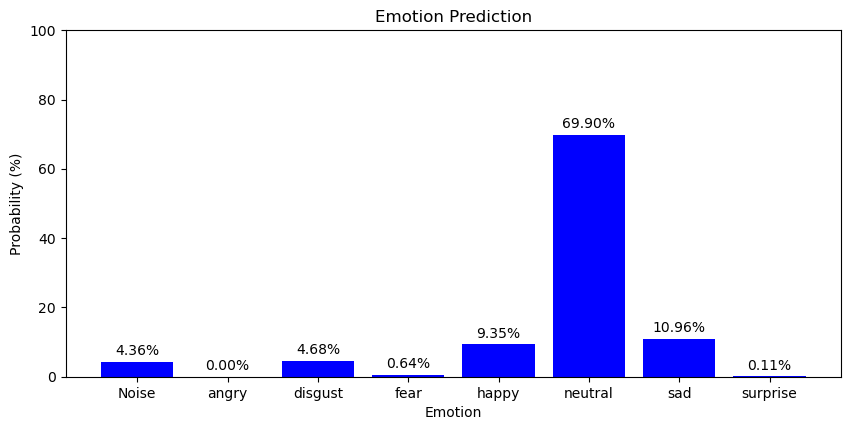

In [47]:
if __name__ == "__main__":
    
    # callback function
    root = tk.Tk() #root window
    ####################################
    # Ensure the window stays on top initially
    root.attributes("-topmost", True)
    root.after(0, lambda: root.attributes("-topmost", False))
    root.lift()
    #####################################
    
    
    plotter = EmotionPlotter(root, visualize_emotion_prediction)
    root.mainloop()

In [48]:
df=pd.read_csv(r'C:\Users\Alkostantini\OneDrive - reutlingen-university.de\git\Prosody_Emotion-Recognition\Models\df_Database.csv')
df

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Alkostantini\\OneDrive - reutlingen-university.de\\git\\Prosody_Emotion-Recognition\\Models\\df_Database.csv'